# IMPORTS

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
from numba import float32

In [21]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 #Fix Collab PTX issue; source : https://github.com/googlecolab/colabtools/issues/5081

 # FROM PREVIOUS LABS :

In [14]:
img = plt.imread('usth.jpg')
img = img.astype(np.uint16)
h, w, _ = img.shape
pixel_count = h * w
flat_img = img.reshape(pixel_count, 3)

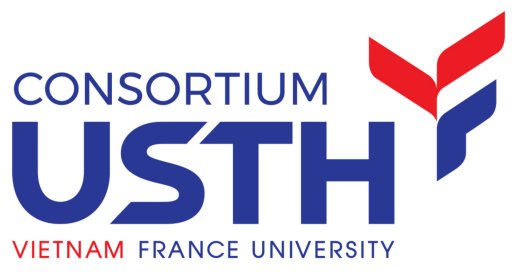

In [15]:
plt.imshow(img)
plt.axis('off')
plt.show()

# LAB 5 WITHOUT SHARED MEMORY

In [27]:
kernel = np.array([
    [1, 2, 3, 4, 3, 2, 1],
    [2, 3, 4, 5, 4, 3, 2],
    [3, 4, 6, 8, 6, 4, 3],
    [4, 5, 8,16, 8, 5, 4],
    [3, 4, 6, 8, 6, 4, 3],
    [2, 3, 4, 5, 4, 3, 2],
    [1, 2, 3, 4, 3, 2, 1]
], dtype=np.float32)

kernel /= kernel.sum()

In [28]:
@cuda.jit
def gaussian_blur_global(src, dst, width, height, kernel):
    x, y = cuda.grid(2)
    if x < width and y < height:
        r = g = b = 0.0
        for ky in range(-3, 4):
            for kx in range(-3, 4):
                nx = x + kx
                ny = y + ky
                if 0 <= nx < width and 0 <= ny < height:
                    n_tid = ny * width + nx
                    w = kernel[ky + 3, kx + 3]  # Already normalized
                    r += src[n_tid, 0] * w
                    g += src[n_tid, 1] * w
                    b += src[n_tid, 2] * w
        tid = y * width + x
        dst[tid, 0] = np.uint16(r)
        dst[tid, 1] = np.uint16(g)
        dst[tid, 2] = np.uint16(b)


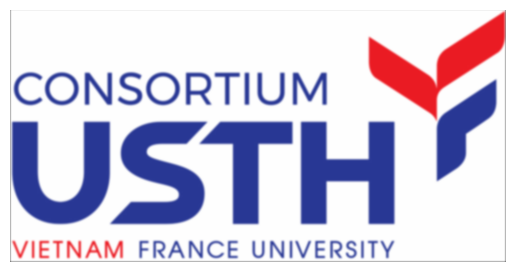

Global memory time: 0.009731054306030273


In [33]:
start_gpu = time.time()
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

blockSize = (16, 16)
gridSize = (
    (w + blockSize[0] - 1) // blockSize[0],
    (h + blockSize[1] - 1) // blockSize[1]
)


gaussian_blur_global[gridSize, blockSize](devSrc, devDst, w, h,kernel)
cuda.synchronize()

hostDst = devDst.copy_to_host()

end_gpu = time.time()
time_gpu = end_gpu - start_gpu

plt.imshow(hostDst.reshape((h, w, 3)))
plt.axis('off')
plt.show()

print("Global memory time:", time_gpu)


In [32]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]

for blockSize in block_sizes:
    gridSize = (
        (w + blockSize[0] - 1) // blockSize[0],
        (h + blockSize[1] - 1) // blockSize[1]
    )

    start_gpu = time.time()
    gaussian_blur_global[gridSize, blockSize](devSrc, devDst, w, h,kernel)
    cuda.synchronize()
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)


(8, 8) time: 0.007012844085693359
(16, 16) time: 0.005898475646972656
(32, 8) time: 0.005532503128051758
(8, 32) time: 0.005408287048339844
(32, 16) time: 0.0055370330810546875
(16, 32) time: 0.005460262298583984
(32, 32) time: 0.00570988655090332


#Lab 5 shared memory

In [46]:
@cuda.jit
def gaussian_blur_shared(src, dst, width, height, kernel_device):
    x, y = cuda.grid(2)
    tid = y * width + x

    kernel_shared = cuda.shared.array((7, 7), dtype=float32)
    if cuda.threadIdx.x < 7 and cuda.threadIdx.y < 7:
        kernel_shared[cuda.threadIdx.y, cuda.threadIdx.x] = kernel_device[cuda.threadIdx.y, cuda.threadIdx.x]
    cuda.syncthreads()

    if x < width and y < height:
        r = g = b = 0.0
        for ky in range(-3, 4):
            for kx in range(-3, 4):
                nx = x + kx
                ny = y + ky
                if 0 <= nx < width and 0 <= ny < height:
                    n_tid = ny * width + nx
                    w = kernel_shared[ky + 3, kx + 3]
                    r += src[n_tid, 0] * w
                    g += src[n_tid, 1] * w
                    b += src[n_tid, 2] * w

        dst[tid, 0] = np.uint16(r)
        dst[tid, 1] = np.uint16(g)
        dst[tid, 2] = np.uint16(b)


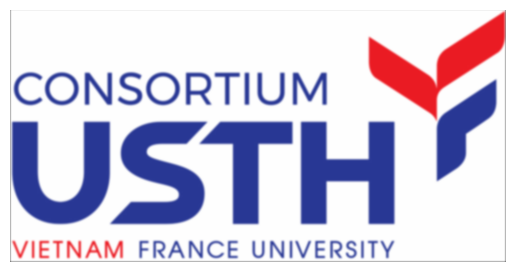

Shared memory time: 0.010776281356811523


In [48]:
start_gpu = time.time()

devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

blockSize = (16, 16)
gridSize = (
    (w + blockSize[0] - 1) // blockSize[0],
    (h + blockSize[1] - 1) // blockSize[1]
)

gaussian_blur_shared[gridSize, blockSize](devSrc, devDst, w, h,kernel)
cuda.synchronize()

hostDst = devDst.copy_to_host()
end_gpu = time.time()
time_gpu = end_gpu - start_gpu

plt.imshow(hostDst.reshape((h, w, 3)))
plt.axis('off')
plt.show()

print("Shared memory time:", time_gpu)


In [51]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]

for blockSize in block_sizes:
    gridSize = (
        (w + blockSize[0] - 1) // blockSize[0],
        (h + blockSize[1] - 1) // blockSize[1]
    )

    start_gpu = time.time()
    gaussian_blur_shared[gridSize, blockSize](devSrc, devDst, w, h,kernel)
    cuda.synchronize()
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)


(8, 8) time: 0.0057756900787353516
(16, 16) time: 0.005594491958618164
(32, 8) time: 0.005326271057128906
(8, 32) time: 0.0052988529205322266
(32, 16) time: 0.005552053451538086
(16, 32) time: 0.006180524826049805
(32, 32) time: 0.005793333053588867
